In [1]:
import cvxpy as cp
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from cycler import cycler
from rpy2.robjects import r, default_converter
from rpy2.robjects.conversion import localconverter, rpy2py
import rpy2.robjects.pandas2ri as pandas2ri
from pairwise_comparison import *

/Users/wangyc/Library/Python/3.9/lib/python/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/", R: "/Users/wangyc/Desktop/cvx"
  warnings.warn(
/Users/wangyc/Library/Python/3.9/lib/python/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "XPC_SERVICE_NAME" redefined by R and overriding existing variable. Current: "application.com.microsoft.VSCode.81788270.81788276", R: "0"
  warnings.warn(
/Users/wangyc/Library/Python/3.9/lib/python/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable. Current: "/var/folders/j7/dz3p77gx07z9hs9dsxyp6kc40000gn/T//RtmpV84P62", R: "/var/folders/j7/dz3p77gx07z9hs9dsxyp6kc40000gn/T//RtmpttojeT"
  warnings.warn(


In [2]:
%load_ext rpy2.ipython

## 1. CEMS

In [3]:
%%R -o CEMS
library(BradleyTerry2)
data("CEMS")
CEMS_pref = CEMS$preferences

In [4]:
r_cems = r['CEMS_pref']
with localconverter(default_converter + pandas2ri.converter):
    cems_df = rpy2py(r_cems)
cems_df.head()

,student,school1,school2,win1,win2,tied,win1.adj,win2.adj
1,1.0,London,Paris,1.0,0.0,0.0,1.0,0.0
2,1.0,London,Milano,1.0,0.0,0.0,1.0,0.0
3,1.0,Paris,Milano,NaN,NaN,NaN,NaN,NaN
4,1.0,London,St.Gallen,0.0,1.0,0.0,0.0,1.0
5,1.0,Paris,St.Gallen,0.0,1.0,0.0,0.0,1.0


In [35]:
# 1) get the full list of schools
schools = sorted(pd.unique(cems_df[['school1','school2']].values.ravel()))

# 2) init an all-zeros win-count matrix
win_matrix_cems = pd.DataFrame(0, index=schools, columns=schools, dtype=int)

# 3) drop any rows where win1, win2, or tied is NaN, then keep only non-ties
clean = (
    cems_df
    .dropna(subset=['win1','win2','tied'])  # toss rows with any NaN in these cols
    .loc[lambda d: d['tied'] == 0]           # ignore actual ties
)

# 4) count wins
for _, row in clean.iterrows():
    i, j = row['school1'], row['school2']
    if row['win1'] > row['win2']:
        win_matrix_cems.loc[i, j] += 1
    elif row['win2'] > row['win1']:
        win_matrix_cems.loc[j, i] += 1

# 5) result
print(win_matrix_cems)

           Barcelona  London  Milano  Paris  St.Gallen  Stockholm
Barcelona          0      67     132    109        134        172
London           217       0     221    186        208        250
Milano           104      56       0     59        135        157
Paris            157      91     121      0        165        203
St.Gallen        144      73     140    119          0        155
Stockholm         90      34     100     70         98          0


In [18]:
def evaluate_metrics(W, n, m, L, eps_values, repetitions=1):
    records = []
    for eps in eps_values:
        metrics = []
        model = individualDP(n=n, k=m, L=L, theta_true=None, W=W)
        for _ in range(repetitions):
            gamma = 8 * 0.25 * L / eps
            lam   = 8 * 1    * L / eps
            noise = np.random.laplace(loc=0, scale=lam, size=n)
            noise_count = np.random.laplace(loc=0, scale=lam/8, size=n)
            model.fit(gamma=gamma, noise=noise)
            pred = model.get_theta()
            pred_vec = model.get_noisy_counts(noise = noise_count)
            
            model.fit(gamma=gamma, noise=np.zeros(n))
            theta_true = model.get_theta()
            true_vec = model.get_noisy_counts(noise=np.zeros(n))

            metrics.append((
                avg_rank_diff(pred, theta_true),
                avg_rank_diff(pred_vec, true_vec),
            ))
        arr = np.array(metrics)
        estimation_mean, count_mean = arr.mean(axis=0)
        estimation_std,  count_std = arr.std(axis=0)
        records.append({
            'eps': eps,
            'estimation_mean':    estimation_mean,
            'estimation_std': estimation_std,
            'count_mean': count_mean,
            'count_std':count_std,
        })
    return pd.DataFrame(records).set_index(['eps'])

In [36]:
df = evaluate_metrics(n=6, m=303, L=15, eps_values=[0.5, 1, 2, 4, 6, 8, 10], W=win_matrix_cems.values, repetitions=1000)

/Users/wangyc/Library/Python/3.9/lib/python/site-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)
/Users/wangyc/Library/Python/3.9/lib/python/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


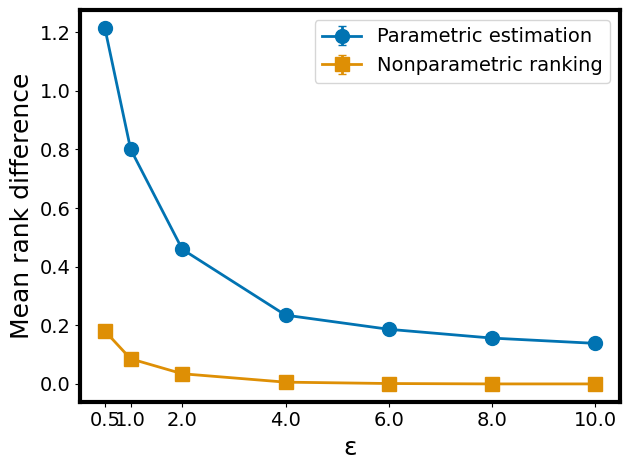

In [38]:
plt.rcParams['axes.prop_cycle']  = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth']  = 2
plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis spines
    'axes.labelsize': 18,      # x/y label font size
    'xtick.labelsize': 14,     # x-tick label size
    'ytick.labelsize': 14,     # y-tick label size
    'legend.fontsize': 14,     # legend text size
})
marker_size = 10

# ── 2) grab your data out of the DF ────────────────────────
eps_vals    = df.index.values
est_mean    = df['estimation_mean'].values
est_std     = df['estimation_std'].values
count_mean  = df['count_mean'].values
count_std   = df['count_std'].values

# ── 3) plot the two curves ─────────────────────────────────
plt.figure()
# estimation‐error curve
plt.errorbar(
    eps_vals, est_mean, yerr=0,
    marker='o',                # circle
    markersize=marker_size,
    linestyle='-',
    capsize=3,
    label='Parametric estimation'
)

# count‐error curve
plt.errorbar(
    eps_vals, count_mean, yerr=0,
    marker='s',                # square
    markersize=marker_size,
    linestyle='-',
    capsize=3,
    label='Nonparametric ranking'
)

# ── 4) labels, ticks, legend ──────────────────────────────
plt.xlabel('ε')
plt.ylabel('Mean rank difference')
plt.xticks(eps_vals)        # ensure only your ε’s appear
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('individual-accuracy-cems.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 2. immig

In [27]:
%%R -o immig
library(prefmod)
data("immig")

Loading required package: gnm
Loading required package: colorspace

Attaching package: ‘prefmod’

The following object is masked from ‘package:BradleyTerry2’:

    baseball



In [28]:
r_immig = r['immig']
with localconverter(default_converter + pandas2ri.converter):
    immig_df = rpy2py(r_immig)
immig_df.head()

,V12,V13,V23,V14,V24,V34,SEX,AGE,NAT
1,-1.0,0.0,1.0,-1.0,1.0,-1.0,2,21,Austria
2,1.0,1.0,-1.0,1.0,0.0,1.0,1,26,Austria
3,1.0,0.0,-1.0,NaN,NaN,1.0,2,22,Austria
4,1.0,1.0,-1.0,1.0,NaN,1.0,2,21,Austria
5,NaN,-1.0,NaN,NaN,NaN,1.0,1,22,Slovakia


In [29]:
# 1) Define your items and init an all‐zero win‐matrix
items = [1, 2, 3, 4]
win_matrix = pd.DataFrame(0, index=items, columns=items, dtype=int)

# 2) Loop through every cell, skipping 0 or NaN
for _, row in immig_df.iterrows():
    for col in immig_df.columns[:6]:           # col is like "V12", "V13", …
        val = row[col]
        if pd.isna(val) or val == 0:
            continue

        # parse a, b from the column name
        a, b = int(col[1]), int(col[2])

        # 1.0 means a beat b; -1.0 means b beat a
        if val == 1.0:
            win_matrix.loc[a, b] += 1
        else:  # val == -1.0
            win_matrix.loc[b, a] += 1

# 3) Inspect your result
print(win_matrix)

    1   2   3   4
1   0  53  34  48
2  12   0  20  31
3  38  43   0  50
4  15  21  14   0


In [40]:
df = evaluate_metrics(n=4, m=98, L=6, eps_values=[0.5, 1, 2, 4, 6, 8, 10], W=win_matrix.values, repetitions=1000)

/Users/wangyc/Library/Python/3.9/lib/python/site-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)
/Users/wangyc/Library/Python/3.9/lib/python/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


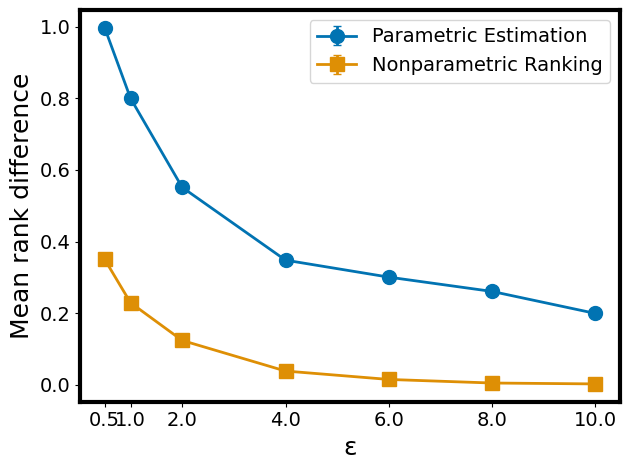

In [41]:
plt.rcParams['axes.prop_cycle']  = cycler('color', sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth']  = 2
plt.rcParams.update({
    'axes.linewidth': 3,       # thicker axis spines
    'axes.labelsize': 18,      # x/y label font size
    'xtick.labelsize': 14,     # x-tick label size
    'ytick.labelsize': 14,     # y-tick label size
    'legend.fontsize': 14,     # legend text size
})
marker_size = 10

# ── 2) grab your data out of the DF ────────────────────────
eps_vals    = df.index.values
est_mean    = df['estimation_mean'].values
est_std     = df['estimation_std'].values
count_mean  = df['count_mean'].values
count_std   = df['count_std'].values

# ── 3) plot the two curves ─────────────────────────────────
plt.figure()
# estimation‐error curve
plt.errorbar(
    eps_vals, est_mean, yerr=0,
    marker='o',                # circle
    markersize=marker_size,
    linestyle='-',
    capsize=3,
    label='Parametric Estimation'
)

# count‐error curve
plt.errorbar(
    eps_vals, count_mean, yerr=0,
    marker='s',                # square
    markersize=marker_size,
    linestyle='-',
    capsize=3,
    label='Nonparametric Ranking'
)

# ── 4) labels, ticks, legend ──────────────────────────────
plt.xlabel('ε')
plt.ylabel('Mean rank difference')
plt.xticks(eps_vals)        # ensure only your ε’s appear
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('individual-accuracy-immig.pdf', format='pdf', bbox_inches='tight')
plt.show()